In [ ]:
# for getting chemcial properties
!pip install rdkit
!pip install git+https://github.com/lmmentel/mendeleev.git@v0.11.0

# torch_geometric lib
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lmmentel/mendeleev.git (to revision v0.11.0) to /tmp/pip-req-build-z93vkyfi
  Running command git clone -q https://github.com/lmmentel/mendeleev.git /tmp/pip-req-build-z93vkyfi
  Running command git checkout -q 9a77d402b82e34a7fdce204509314d8989ceefff
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 865 kB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 28.1 MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.11.0-py3-none-any.whl size=296444 sha256=62206fdd0b941ac6a8918aa4dc6e3d656c0edb7c0f8b422dd49b98a216ee7e1f
  Stored in directory: /tmp/pip-ephem-wheel-cache-mr_0st2w/wheel

1.12.1+cu113
     |████████████████████████████████| 8.9 MB 14.7 MB/s 
     |████████████████████████████████| 3.5 MB 16.2 MB/s 
     |████████████████████████████████| 280 kB 4.1 MB/s 


In [ ]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch_geometric as geo
import torch_geometric.utils 
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# 1 data load

models : GCN, GCN+a, GCN+g, GCN+a+g, GGNN

property : logP, TPSA, QED, SAS (ZINC dataset) and pve (CEP dataset)



> The node features correspond to atom
descriptors including atom type, number of attached hydrogens,
number of valencies, and aromaticity indicator. We represent all
the descriptors with an one-hot encoded vector.



## 1-1 generating feature matrix via the paper way

In [ ]:
import rdkit
from rdkit import Chem 
from rdkit.Chem.QED import qed
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.rdMolDescriptors import CalcTPSA
from rdkit.Contrib.SA_Score.sascorer import calculateScore


atomSymbolz = ['Ag', 'Al', 'As', 'Au', 'B', 'Br', 'C', 'Ca', 'Cd', 'Cl', 'Co', 'Cr', 'Cu', 'F', 'Fe', 'Ge', 'H', 'Hg', 'I', 'K', 'Li', 'Mg', 'Mn', 'N', 'Na', 'Ni', 'O', 'P', 'Pb', 'Pd', 'Pt', 'S', 'Sb', 'Se', 'Si', 'Sn', 'Ti', 'Tl', 'V', 'Zn']


def make_onehot_features(atom):
  ret = []
  ret += list(map(lambda r: r == atom.GetSymbol(), atomSymbolz))
  ret += list(map(lambda r: r == atom.GetDegree(), (0,1,2,3,4,5)))
  ret += list(map(lambda r: r == atom.GetImplicitValence(), (0,1,2,3,4,5)))
  ret += [1 if atom.GetIsAromatic() else 0]

  return np.array(ret) # (atom X 53)

def get_targetProperties(mol):
  l       = torch.tensor(MolLogP(mol), dtype=torch.float).view(1,1)
  t       = torch.tensor(CalcTPSA(mol), dtype=torch.float).view(1,1)
  q       = torch.tensor(qed(mol), dtype=torch.float).view(1,1)
  s       = torch.tensor(calculateScore(mol) , dtype=torch.float).view(1,1)

  return l, t, q, s

# for smiles in tqdm_notebook(SMILES):

def molToData(mol):
  max_atoms = 55
  
  adj = Chem.GetAdjacencyMatrix(mol) # return np.ndarray (N x N)
  N = adj.shape[0]
  self_added_adj = adj + np.eye(N, dtype=np.int32) # self node information

  padded_adj = np.zeros((max_atoms, max_atoms))
  padded_adj[:N, :N] = self_added_adj

  # edge_idx = torch.tensor(adj).to_sparse() !! ERR !! 
  bonds = []
  for i in range(mol.GetNumAtoms()):
    for j in range(mol.GetNumAtoms()):
      if adj[i,j] == 1:
        bonds.append([i,j])

  # get feature X  
  atomic_f = []
  padded_atomic_f = []

  pad = np.zeros((max_atoms, 53))
  temp_atomic_f = []

  for atom in mol.GetAtoms():
    onehot_f = make_onehot_features(atom)
    temp_atomic_f.append(onehot_f)
    atomic_f.append(onehot_f)

  pad[:len(temp_atomic_f), :] = temp_atomic_f
  padded_atomic_f.append(pad)

  padded_atomic_f = np.array(padded_atomic_f)
  atomic_f        = np.array(atomic_f)

  # converting
  atomic_f = torch.tensor(atomic_f, dtype=torch.float)
  bonds    = torch.tensor(bonds, dtype=torch.long).t().contiguous()
  padded_atomic_f = torch.tensor(padded_atomic_f, dtype=torch.float)
  padded_adj = torch.tensor(padded_adj, dtype=torch.float)

  return atomic_f, bonds, padded_atomic_f, padded_adj
  
def load_ZINCdataset1(dataPath):
  f = open(dataPath)
  SMILES = f.readlines()

  print(f'# of SMILES data: {len(SMILES)}')

  data_list = []

  for smiles in tqdm(SMILES[:10000]):
    mol = Chem.MolFromSmiles(smiles.strip())

    atomic_f, bonds, padded_atomic_f, padded_adj = molToData(mol)
    logP, tpsa, qed, sas = get_targetProperties(mol)

    data_list.append(
                      np.array([smiles,
                      Data(x=atomic_f, y=logP, edge_index=bonds,
                            adj=padded_adj, shaped_x=padded_atomic_f, smiles=smiles,
                            LogP=logP, TPSA=tpsa, QED=qed, SAS=sas)],
                     dtype=object)
                    )

  data_list = np.array(data_list) # (N x 2; SMILES, DATA)

  return data_list

def load_CEPdataset1(dataPath, valuePath):
  f = open(dataPath)
  SMILES = f.readlines()

  values = np.load(valuePath)
  values = values.astype(np.float64)
  values = torch.tensor(values, dtype=torch.float).view(-1, 1)

  print(f'# of SMILES data: {len(SMILES)}')

  data_list = []

  for idx, smiles in tqdm(enumerate(SMILES[:10000])):
    mol = Chem.MolFromSmiles(smiles.strip())

    atomic_f, bonds, padded_atomic_f, padded_adj = molToData(mol)

    data_list.append(
                      np.array([smiles,
                      Data(x=atomic_f, y=values[idx].view(1,1), edge_index=bonds,
                            adj=padded_adj, shaped_x=padded_atomic_f, smiles=smiles)],
                     dtype=object)
                    )
  data_list = np.array(data_list) # (N x 2; SMILES, DATA)

  return data_list


## 1-2 variation of the features

In [ ]:
def get_atomicFeature_table():
  from mendeleev.fetch import fetch_table
  ptable = fetch_table('elements')
  ptable = ptable.select_dtypes(include=np.number)
  
  feature_labels = ['atomic_number','atomic_weight', 'atomic_radius', 'atomic_volume', 'dipole_polarizability', 
                   'vdw_radius', 'en_pauling','boiling_point', 'electron_affinity', 
                   'en_allen', 'en_ghosh']


  ret = ptable[feature_labels].to_numpy(copy=True)
  del ptable

  return ret

def get_molecluarProperty(mol):
  from rdkit.Chem import Descriptors 

  MolWt                     = rdkit.Chem.Descriptors.MolWt(mol)
  HeavyAtomMolWt            = rdkit.Chem.Descriptors.HeavyAtomMolWt(mol)
  NumValenceElectrons       = rdkit.Chem.Descriptors.NumValenceElectrons(mol)
  FractionCSP3              = rdkit.Chem.Lipinski.FractionCSP3(mol)
  HeavyAtomCount            = rdkit.Chem.Lipinski.HeavyAtomCount(mol)
  NHOHCount                 = rdkit.Chem.Lipinski.NHOHCount(mol)
  NOCount                   = rdkit.Chem.Lipinski.NOCount(mol)
  NumAliphaticCarbocycles   = rdkit.Chem.Lipinski.NumAliphaticCarbocycles(mol)
  NumAliphaticHeterocycles  = rdkit.Chem.Lipinski.NumAliphaticHeterocycles(mol)
  NumAliphaticRings         = rdkit.Chem.Lipinski.NumAliphaticRings(mol)
  NumAromaticCarbocycles    = rdkit.Chem.Lipinski.NumAromaticCarbocycles(mol)
  NumAromaticHeterocycles   = rdkit.Chem.Lipinski.NumAromaticHeterocycles(mol)
  NumAromaticRings          = rdkit.Chem.Lipinski.NumAromaticRings(mol)
  NumHAcceptors             = rdkit.Chem.Lipinski.NumHAcceptors(mol)
  NumHDonors                = rdkit.Chem.Lipinski.NumHDonors(mol)
  NumHeteroatoms            = rdkit.Chem.Lipinski.NumHeteroatoms(mol)
  NumRotatableBonds         = rdkit.Chem.Lipinski.NumRotatableBonds(mol)
  RingCount                 = rdkit.Chem.Lipinski.RingCount(mol)
  MolMR                     = rdkit.Chem.Crippen.MolMR(mol)
  
  x = np.array([MolWt, HeavyAtomMolWt, NumValenceElectrons, FractionCSP3, HeavyAtomCount, NHOHCount, NOCount, NumAliphaticCarbocycles, NumAliphaticHeterocycles, NumAliphaticRings, NumAromaticCarbocycles, NumAromaticHeterocycles, NumAromaticRings, NumHAcceptors, NumHDonors, NumHeteroatoms, NumRotatableBonds, RingCount, MolMR])
  
  return x

def dataFromMol(mol):
  max_atoms = 55 

  adj = Chem.GetAdjacencyMatrix(mol) # return np.ndarray (N x N)
  N = adj.shape[0]
  self_added_adj = adj + np.eye(N, dtype=np.int32) # self node information

  padded_adj = np.zeros((max_atoms, max_atoms))
  padded_adj[:N, :N] = self_added_adj

  # edge_idx = torch.tensor(adj).to_sparse() !! ERR !! 
  bonds = []
  for i in range(mol.GetNumAtoms()):
    for j in range(mol.GetNumAtoms()):
      if adj[i,j] == 1:
        bonds.append([i,j])

  # get feature X  
  f_table = get_atomicFeature_table()
  atomic_f = []
  padded_atomic_f = []

  pad = np.zeros((max_atoms, 15))
  temp_atomic_f = []

  for atom in mol.GetAtoms():
    value_f = np.concatenate([f_table[atom.GetAtomicNum()-1, :],
                                    [atom.GetTotalNumHs(),
                                    atom.GetDegree(),
                                    atom.GetImplicitValence(),
                                    atom.GetIsAromatic() * 1]])
    
    temp_atomic_f.append(value_f)
    atomic_f.append(value_f)

  pad[:len(temp_atomic_f), :] = temp_atomic_f
  padded_atomic_f.append(pad)

  padded_atomic_f = np.array(padded_atomic_f)
  atomic_f        = np.array(atomic_f)

  mol_f = get_molecluarProperty(mol)
  
  # converting
  atomic_f = torch.tensor(atomic_f, dtype=torch.float)
  mol_f    = torch.tensor(mol_f, dtype=torch.float).view(1,-1)
  bonds    = torch.tensor(bonds, dtype=torch.long).t().contiguous()
  padded_atomic_f = torch.tensor(padded_atomic_f, dtype=torch.float)
  padded_adj = torch.tensor(padded_adj, dtype=torch.float)

  return atomic_f, mol_f, bonds, padded_atomic_f, padded_adj

  
def normalize_feature(data):
  def standarize(src_data):
    means = src_data.mean(dim=0, keepdim=True)
    stds  = src_data.std(dim=0, keepdim=True)
    
    return means, stds

  atomic_f = []
  padded_atomic_f = []
  mol_f = []

  for one in data:
    atomic_f.append(one.x)
    mol_f.append(one.mol_f)
    padded_atomic_f.append(one.shaped_x)

  atomic_f = torch.cat(atomic_f, dim=0)
  mol_f    = torch.cat(mol_f, dim=0)
  padded_atomic_f = torch.cat(padded_atomic_f, dim=0)

  a_means, a_stds = standarize(atomic_f)
  m_means, m_stds = standarize(mol_f)


  for idx, one in enumerate(data):
    one.x = (one.x - a_means) / a_stds
    one.mol_f  = (one.mol_f - m_means) / m_stds
    one.shaped_x = (one.shaped_x - a_means) / a_stds

  return data

def load_ZINCdataset2(dataPath):
  f = open(dataPath)
  SMILES = f.readlines()

  print(f'# of SMILES data: {len(SMILES)}')

  data_list = []

  for smiles in tqdm(SMILES[:10000]):
    mol = Chem.MolFromSmiles(smiles.strip())

    atomic_f, mol_f, bonds, padded_atomic_f, padded_adj = dataFromMol(mol)
    logP, tpsa, qed, sas = get_targetProperties(mol)

    data_list.append(
                      np.array([smiles,
                      Data(x=atomic_f, y=logP, edge_index=bonds,
                            adj=padded_adj, shaped_x=padded_atomic_f,
                            smiles=smiles, mol_f=mol_f,
                            LogP=logP, TPSA=tpsa, QED=qed, SAS=sas)],
                     dtype=object)
                    )

  data_list = np.array(data_list) # (N x 2; SMILES, DATA)

  ## scale is matter
  data_list[:, 1] = normalize_feature(data_list[:, 1])
  
  return data_list

def load_CEPdataset2(dataPath, valuePath):
  f = open(dataPath)
  SMILES = f.readlines()

  values = np.load(valuePath)
  values = values.astype(np.float64)
  values = torch.tensor(values, dtype=torch.float).view(-1, 1)

  print(f'# of SMILES data: {len(SMILES)}')

  data_list = []

  for idx, smiles in tqdm(enumerate(SMILES[:10000])):
    mol = Chem.MolFromSmiles(smiles.strip())

    atomic_f, mol_f, bonds, padded_atomic_f, padded_adj = dataFromMol(mol)

    data_list.append(
                      np.array([smiles,
                      Data(x=atomic_f, y=values[idx].view(1,1), edge_index=bonds,
                            adj=padded_adj, shaped_x=padded_atomic_f,
                            smiles=smiles, mol_f=mol_f)],
                     dtype=object)
                    )
  data_list = np.array(data_list) # (N x 2; SMILES, DATA)

  data_list[:, 1] = normalize_feature(data_list[:, 1])

  return data_list


# 2 model implementation

## 2-1 GatedSkipConnection (GATE) & SkipConnection

In [ ]:
class GatedSkipConnection(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(GatedSkipConnection, self).__init__()

    self.input_dim = input_dim
    self.output_dim = output_dim

    if self.input_dim is not self.output_dim:
      self.proj = nn.Linear(self.input_dim, self.output_dim, bias=False)
    self.U1 = nn.Linear(self.output_dim, self.output_dim)
    self.U2 = nn.Linear(self.output_dim, self.output_dim)

    self.sigmoid = nn.Sigmoid()

    
  def get_gateCoef(self, f_x, id_x):
    h1 = self.U1(f_x)
    h2 = self.U2(id_x)

    output = self.sigmoid(h1 + h2)

    return output

  def forward(self, f_x, id_x):

    if self.input_dim is not self.output_dim:
      id_x = self.proj(id_x)

    z = self.get_gateCoef(f_x, id_x)
    output = z * f_x + (1.0 - z) * id_x
    
    return output

class SkipConnection(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SkipConnection, self).__init__()

    self.input_dim = input_dim
    self.output_dim = output_dim

    if self.input_dim is not self.output_dim:
      self.proj = nn.Linear(input_dim, output_dim, bias=False)

  def forward(self, f_x, id_x):
    if self.input_dim is not self.output_dim:
      id_x = self.proj(id_x) 
    
    output = f_x + id_x

    return output

## 2-2 Graph Convolutional Networks

**1 Attention and gate-augmented graph convoutional networks**
- Graph Convolutional Networks (GCN) with skip connection
- Graph Convolutional Networks (GCN) with gated skip connection
- Graph Attention Networks (GAT) with skip connection
- Graph Attention Networks (GAT) with gated skip connection 

**2 Graph Isomorphic Networks**
- Graph Isomorphic Networks (GIN) 
- Graph Convolution Netowkrs (GCN)
- Graph SAmple and aggreGatE (SAGE); mean aggregator version

**3 Modified SAGE layer**



---



### 1) Attention and Gate-augmented Graph Convutional Networks

1. GCNwithSkip
2. GCNwithGATE
3. GATwithSkip
4. GATwithGATE

In [ ]:
class GCNlayer(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(GCNlayer, self).__init__()

    self.linear = nn.Linear(input_dim, output_dim)
    # self.norm   = nn.BatchNorm1d(55)

  def forward(self, x, adj):
    h = self.linear(x)
    output = torch.matmul(adj, h)
    # h = self.norm(h)
    
    return output

In [ ]:
class GINlayer(nn.Module):
  def __init__(self, mlp, input_dim, output_dim, eps=0):
    super(GCNlayer, self).__init__()

    self.mlp = mlp
    if eps:
      self.eps = nn.Parameter(torch.Tensor((eps)))
    else:
      self.eps = None
    

  def forward(self, x, adj):

    if self.eps is not None:
      # A + (1+eps) * I
      adj = adj - torch.eye(adj.shape[0], dtype=torch.float)
      eye = torch.eye(adj.shape[0], dtype=torch.float)
      adj = adj + (1 + self.eps) * eye
      
    h = torch.matmul(adj, x)
    output = self.mlp(h)
    
    return output

In [ ]:
class GCNwithSkip(nn.Module):
  def __init__(self, args):
    super(GCNwithSkip, self).__init__()

    self.mol_dim = args.mol_dim

    self.conv1 = GCNlayer(args.input_dim, args.hidden_dim)
    self.conv2 = GCNlayer(args.hidden_dim, args.hidden_dim)
    self.conv3 = GCNlayer(args.hidden_dim, args.hidden_dim)

    self.skip1 = SkipConnection(args.input_dim, args.hidden_dim)
    self.skip2 = SkipConnection(args.hidden_dim, args.hidden_dim)
    self.skip3 = SkipConnection(args.hidden_dim, args.hidden_dim)

    self.readout = nn.Linear(args.hidden_dim, args.latent_dim)

    self.mlp = nn.Sequential(
        nn.Linear(args.latent_dim + args.mol_dim, args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, 1)
    )

    self.act = nn.ReLU()
    
  def forward(self, G):
    
    edge = G.adj.reshape(G.batch.max().item() +1, -1 , G.adj.shape[-1])
    x = G.shaped_x.reshape(G.batch.max().item() +1, -1 , G.x.shape[-1])

    id1 = x
    h1 = self.conv1(x, edge)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1) 

    id2 = h1
    h2 = self.conv2(h1, edge)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.act(h3)
    h3 = self.skip3(h3, id3) 

    readout = torch.sum(self.readout(h3), 1)

    if self.mol_dim >0 :
      readout = torch.cat( (readout, G.mol_f), dim=1)
    
    output = self.mlp(readout)

    return output
  

In [ ]:
class GCNwithGate(nn.Module):
  def __init__(self, args):
    super(GCNwithGate, self).__init__()

    self.mol_dim = args.mol_dim

    self.conv1 = GCNlayer(args.input_dim, args.hidden_dim)
    self.conv2 = GCNlayer(args.hidden_dim, args.hidden_dim)
    self.conv3 = GCNlayer(args.hidden_dim, args.hidden_dim)

    self.skip1 = GatedSkipConnection(args.input_dim, args.hidden_dim)
    self.skip2 = GatedSkipConnection(args.hidden_dim, args.hidden_dim)
    self.skip3 = GatedSkipConnection(args.hidden_dim, args.hidden_dim)

    self.readout = nn.Linear(args.hidden_dim, args.latent_dim)

    self.mlp = nn.Sequential(
        nn.Linear(args.latent_dim + args.mol_dim , args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, 1)
    )

    self.act = nn.ReLU()
    
  def forward(self, G):
    
    edge = G.adj.reshape(G.batch.max().item() +1, -1 , G.adj.shape[-1])
    x = G.shaped_x.reshape(G.batch.max().item() +1, -1 , G.x.shape[-1])
    
    id1 = x
    h1 = self.conv1(x, edge)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1) 

    id2 = h1
    h2 = self.conv2(h1, edge)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.act(h3)
    h3 = self.skip3(h3, id3) 

    # h3:(B, atom, 32) -> readout(h3): (B, atom, 512) -> readout:(B, 512)
    readout = torch.sum(self.readout(h3), 1)

    if self.mol_dim >0 :
      readout = torch.cat( (readout, G.mol_f), dim=1)
    
    output = self.mlp(readout)

    return output
  

In [ ]:
# multihead attention
class GATlayer(nn.Module):
  def __init__(self, input_dim, output_dim, head_num):
    super(GATlayer, self).__init__()
    self.W1 = nn.ModuleList([nn.Linear(input_dim, output_dim) for _ in range(head_num)])
    self.att_weight = nn.ModuleList([nn.Linear(input_dim, output_dim) for _ in range(head_num)])
    self.act = nn.ReLU()
    self.head_num = head_num

  def attention(self, x, adj):
    attn = []
    for layer in self.att_weight:
      h = layer(x)
      ch = torch.matmul(h.transpose(1,2), adj)
      hch = torch.matmul(h, ch)
      attn.append(torch.tanh(hch))

    return attn
  
  def forward(self, x, adj):
    attns = self.attention(x, adj)
    outputs = []      
    for i in range (len(attns)):
      h = self.W1[i](x)
      outputs.append(torch.matmul(attns[i],h))
    outputs = torch.stack(outputs)
    output = torch.sum(outputs, dim=0, keepdim=False)
    output /= self.head_num
    output = self.act(output)

    return output 

In [ ]:
class GATwithSkip(nn.Module):
  def __init__(self, args):
    super(GATwithSkip, self).__init__()

    self.mol_dim = args.mol_dim

    self.conv1 = GATlayer(args.input_dim, args.hidden_dim, args.head_num)
    self.conv2 = GATlayer(args.hidden_dim, args.hidden_dim, args.head_num)
    self.conv3 = GATlayer(args.hidden_dim, args.hidden_dim, args.head_num)

    self.skip1 = SkipConnection(args.input_dim, args.hidden_dim)
    self.skip2 = SkipConnection(args.hidden_dim, args.hidden_dim)
    self.skip3 = SkipConnection(args.hidden_dim, args.hidden_dim)

    self.readout = nn.Linear(args.hidden_dim, args.latent_dim)

    self.mlp = nn.Sequential(
        nn.Linear(args.latent_dim + args.mol_dim, args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, 1)
    )

    self.act = nn.ReLU()
    
  def forward(self, G):
    
    edge = G.adj.reshape(G.batch.max().item() +1, -1 , G.adj.shape[-1])
    x = G.shaped_x.reshape(G.batch.max().item() +1, -1 , G.x.shape[-1])

    id1 = x
    h1 = self.conv1(x, edge)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1) 

    id2 = h1
    h2 = self.conv2(h1, edge)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.act(h3)
    h3 = self.skip3(h3, id3) 

    readout = torch.sum(self.readout(h3), 1)

    if self.mol_dim >0 :
      readout = torch.cat( (readout, G.mol_f), dim=1)
    
    output = self.mlp(readout)

    return output

In [ ]:
class GATwithGate(nn.Module):
  def __init__(self, args):
    super(GATwithGate, self).__init__()

    self.mol_dim = args.mol_dim

    self.conv1 = GATlayer(args.input_dim, args.hidden_dim, args.head_num)
    self.conv2 = GATlayer(args.hidden_dim, args.hidden_dim, args.head_num)
    self.conv3 = GATlayer(args.hidden_dim, args.hidden_dim, args.head_num)

    self.skip1 = GatedSkipConnection(args.input_dim, args.hidden_dim)
    self.skip2 = GatedSkipConnection(args.hidden_dim, args.hidden_dim)
    self.skip3 = GatedSkipConnection(args.hidden_dim, args.hidden_dim)

    self.readout = nn.Linear(args.hidden_dim, args.latent_dim)

    self.mlp = nn.Sequential(
        nn.Linear(args.latent_dim + args.mol_dim , args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, 1)
    )

    self.act = nn.ReLU()
    
  def forward(self, G):
    
    edge = G.adj.reshape(G.batch.max().item() +1, -1 , G.adj.shape[-1])
    x = G.shaped_x.reshape(G.batch.max().item() +1, -1 , G.x.shape[-1])
    
    id1 = x
    h1 = self.conv1(x, edge)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1) 

    id2 = h1
    h2 = self.conv2(h1, edge)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.act(h3)
    h3 = self.skip3(h3, id3) 

    # h3:(B, atom, 32) -> readout(h3): (B, atom, 512) -> readout:(B, 512)
    readout = torch.sum(self.readout(h3), 1)

    if self.mol_dim >0 :
      readout = torch.cat( (readout, G.mol_f), dim=1)
    
    output = self.mlp(readout)

    return output

### 2) Graph Isomorphic Netwokrs
1. GIN
2. GCN
3. SAGE

In [ ]:
class MLPcell(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim):
    super(MLPcell, self).__init__()

    self.mlp = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, output_dim),
    )

  def forward(self, x):

    output = self.mlp(x)

    return output

In [ ]:
class GIN(nn.Module):
  def __init__(self, args):
      super(GIN, self).__init__()

      self.mol_dim = args.mol_dim

      self.conv1 = geo.nn.GINConv(nn=MLPcell(args.input_dim, args.hidden_dim, args.hidden_dim))
      self.conv2 = geo.nn.GINConv(nn=MLPcell(args.hidden_dim, args.hidden_dim, args.hidden_dim))
      self.conv3 = geo.nn.GINConv(nn=MLPcell(args.hidden_dim, args.hidden_dim, args.hidden_dim))
      self.conv4 = geo.nn.GINConv(nn=MLPcell(args.hidden_dim, args.hidden_dim, args.hidden_dim))
      self.conv5 = geo.nn.GINConv(nn=MLPcell(args.hidden_dim, args.hidden_dim, args.hidden_dim))

      self.norm1 = geo.nn.BatchNorm(args.hidden_dim)
      self.norm2 = geo.nn.BatchNorm(args.hidden_dim)
      self.norm3 = geo.nn.BatchNorm(args.hidden_dim)
      self.norm4 = geo.nn.BatchNorm(args.hidden_dim)
      self.norm5 = geo.nn.BatchNorm(args.hidden_dim)

      self.dropout = nn.Dropout(args.dropout)

      self.mlp = nn.Sequential(
          nn.Linear(args.hidden_dim*5 +args.input_dim + self.mol_dim, args.latent_dim),
          nn.ReLU(),
          nn.Linear(args.latent_dim, args.latent_dim),
          nn.ReLU(),
          nn.Linear(args.latent_dim, 1)
      )

      self.act = nn.ReLU()

  def forward(self, G):
    edge = G.edge_index


    h1 = self.conv1(G.x,  edge)
    h1 = self.norm1(h1)
    h1 = self.act(h1)

    h2 = self.conv2(h1, edge)
    h2 = self.norm2(h2)
    h2 = self.act(h2)

    h3 = self.conv3(h2, edge)
    h3 = self.norm3(h3)
    h3 = self.act(h3)

    h4 = self.conv4(h3, edge)
    h4 = self.norm4(h4)
    h4 = self.act(h4)

    h5 = self.conv5(h4, edge)
    h5 = self.norm5(h5)
    h5 = self.act(h5)


    h0 = geo.nn.global_add_pool(G.x, G.batch)
    h1 = geo.nn.global_add_pool(h1, G.batch)
    h2 = geo.nn.global_add_pool(h2, G.batch)
    h3 = geo.nn.global_add_pool(h3, G.batch)
    h4 = geo.nn.global_add_pool(h4, G.batch)
    h5 = geo.nn.global_add_pool(h5, G.batch)

    h = torch.cat( (h0, h1, h2, h3, h4, h5), dim=1 )
    if self.mol_dim > 0:
      h = torch.cat( (h, G.mol_f), dim=1)
    
    output = self.mlp(h)

    return output

In [ ]:
class GCN(nn.Module):
  def __init__(self, args):
    super(GCN, self).__init__()

    self.mol_dim = args.mol_dim
    self.hidden_dim = args.hidden_dim

    self.conv1 = geo.nn.GCNConv(args.input_dim, args.hidden_dim)
    self.skip1 = SkipConnection(args.input_dim, args.hidden_dim, args.concat)    

    if args.concat:
      self.hidden_dim *= 2
    self.conv2 = geo.nn.GCNConv(self.hidden_dim, self.hidden_dim)
    self.skip2 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)

    if args.concat:
      self.hidden_dim *= 2
    self.conv3 = geo.nn.GCNConv(self.hidden_dim, self.hidden_dim)
    self.skip3 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)

    # the origin version used softmax fucntion for 'node classification' 
    if args.concat:
      self.hidden_dim *= 2
    self.dropout = nn.Dropout(args.dropout)
    self.mlp = nn.Sequential(
          nn.Linear(self.hidden_dim + self.mol_dim, args.latent_dim),
          nn.ReLU(),
          nn.Linear(args.latent_dim, args.latent_dim),
          nn.ReLU(),
          nn.Linear(args.latent_dim, 1)
      )

    self.act = nn.ReLU()

  def forward (self, G):
    edge = G.edge_index

    id1 = G.x
    h1 = self.conv1(G.x, edge)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1)

    id2 = h1
    h2 = self.conv2(h1,  edge)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.act(h2)
    h3 = self.skip3(h3, id3)

    h = geo.nn.global_add_pool(h3, G.batch)

    if self.mol_dim > 0:
      h = torch.cat( (h, G.mol_f), dim=1)

    output = self.mlp(h)

    return output

In [ ]:
class SAGE(nn.Module):
  def __init__(self, args):
    super(SAGE, self).__init__()

    self.mol_dim = args.mol_dim
    
    

    self.hidden_dim = args.hidden_dim

    self.conv1 = geo.nn.SAGEConv(args.input_dim, args.hidden_dim, aggr=args.aggr)
    self.norm1 = geo.nn.LayerNorm(args.hidden_dim)
    self.skip1 = SkipConnection(args.input_dim, args.hidden_dim, args.concat)
    
    if args.concat:
      self.hidden_dim *= 2
    self.conv2 = geo.nn.SAGEConv(self.hidden_dim, self.hidden_dim, aggr=args.aggr)
    self.skip2 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm2 = geo.nn.LayerNorm(self.hidden_dim)

    if args.concat:
      self.hidden_dim *= 2
    self.conv3 = geo.nn.SAGEConv(self.hidden_dim, self.hidden_dim, aggr=args.aggr)
    self.skip3 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm3 = geo.nn.LayerNorm(self.hidden_dim)
    
    if args.concat:
      self.hidden_dim *= 2
    self.conv4 = geo.nn.SAGEConv(self.hidden_dim, self.hidden_dim, aggr=args.aggr)
    self.skip4 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm4 = geo.nn.LayerNorm(self.hidden_dim)


    if args.concat:
      self.hidden_dim *= 2
    self.conv5 = geo.nn.SAGEConv(self.hidden_dim, self.hidden_dim, aggr=args.aggr)
    self.skip5 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm5 = geo.nn.LayerNorm(self.hidden_dim)


    # Chen and Zhu achieve superior performance by optimizing the GraphSAGE hyperparameters with layer normalization

    if args.concat:
      self.hidden_dim *= 2
    self.dropout = nn.Dropout(args.dropout)
    self.mlp = nn.Sequential(
          nn.Linear(self.hidden_dim + self.mol_dim, args.latent_dim),
          nn.ReLU(),
          nn.Linear(args.latent_dim, args.latent_dim),
          nn.ReLU(),
          nn.Linear(args.latent_dim, 1)
      )

    self.act = nn.ReLU()

  def forward (self, G):
    edge = G.edge_index

    id1 = G.x
    h1 = self.conv1(G.x, edge)
    h1 = self.norm1(h1)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1)

    id2 = h1
    h2 = self.conv2(h1,  edge)
    h2 = self.norm2(h2)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.norm3(h3)
    h3 = self.act(h3)
    h3 = self.skip3(h3, id3)

    id4 = h3
    h4 = self.conv4(h3, edge)
    h4 = self.norm4(h4)
    h4 = self.act(h4)
    h4 = self.skip4(h4, id4)

    id5 = h4
    h5 = self.conv5(h4, edge)
    h5 = self.norm5(h5)
    h5 = self.act(h5)
    h5 = self.skip5(h5, id5)


    h = geo.nn.global_add_pool(h5, G.batch)

    if self.mol_dim > 0:
      h = torch.cat( (h, G.mol_f), dim=1)

    output = self.mlp(h)

    return output

### 3) Modified SAGE layer

In [ ]:
from typing import List, Optional, Tuple, Union

import torch.nn.functional as F
from torch import Tensor
from torch.nn import LSTM
from torch_sparse import SparseTensor, matmul

from torch_geometric.nn.aggr import Aggregation, MultiAggregation
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import Adj, OptPairTensor, Size

class modified_SAGEConv(MessagePassing):
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        self_nn=None,
        neighbor_nn=None,
        aggr: Optional[Union[str, List[str], Aggregation]] = "add",
        normalize: bool = False,
        root_weight: bool = True,
        project: bool = False,
        bias: bool = True,
        **kwargs,
    ):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.root_weight = root_weight
        self.project = project

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        if aggr == 'lstm':
            kwargs.setdefault('aggr_kwargs', {})
            kwargs['aggr_kwargs'].setdefault('in_channels', in_channels[0])
            kwargs['aggr_kwargs'].setdefault('out_channels', in_channels[0])

        super().__init__(aggr, **kwargs)

        if self.project:
            self.lin = Linear(in_channels[0], in_channels[0], bias=True)

        if self.aggr is None:
            self.fuse = False  # No "fused" message_and_aggregate.
            self.lstm = LSTM(in_channels[0], in_channels[0], batch_first=True)

        if isinstance(self.aggr_module, MultiAggregation):
            aggr_out_channels = self.aggr_module.get_out_channels(
                in_channels[0])
        else:
            aggr_out_channels = in_channels[0]

        if neighbor_nn is None:
          self.mlp_l = Linear(aggr_out_channels, out_channels, bias=bias)
        else:
          self.mlp_l = neighbor_nn
        if self.root_weight:
          if self_nn is None:
            self.mlp_r = Linear(in_channels[1], out_channels, bias=False)
          else:
            self.mlp_r = self_nn
        

        self.reset_parameters()

    def reset_parameters(self):
        if self.project:
            self.lin.reset_parameters()
        self.aggr_module.reset_parameters()
        # self.mlp_l.reset_parameters()
        # if self.root_weight:
        #     self.mlp_r.reset_parameters()


    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                size: Size = None) -> Tensor:
        """"""
        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        if self.project and hasattr(self, 'lin'):
            x = (self.lin(x[0]).relu(), x[1])

        # propagate_type: (x: OptPairTensor)
        out = self.propagate(edge_index, x=x, size=size)
        out = self.mlp_l(out)

        x_r = x[1]
        if self.root_weight and x_r is not None:
            out = out + self.mlp_r(x_r)

        if self.normalize:
            out = F.normalize(out, p=2., dim=-1)

        return out


    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor,
                              x: OptPairTensor) -> Tensor:
        adj_t = adj_t.set_value(None, layout=None)
        return matmul(adj_t, x[0], reduce=self.aggr)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, aggr={self.aggr})')


In [ ]:
class modified_SAGE(nn.Module):
  def __init__(self, args):
    super(modified_SAGE, self).__init__()

    self.mol_dim = args.mol_dim

    self.hidden_dim = args.hidden_dim

    self.conv1 = modified_SAGEConv(args.input_dim, args.hidden_dim,
                                   self_nn=MLPcell(args.input_dim, args.hidden_dim, args.hidden_dim),
                                   neighbor_nn=MLPcell(args.input_dim, args.hidden_dim, args.hidden_dim))
    self.norm1 = geo.nn.LayerNorm(args.hidden_dim)
    self.skip1 = SkipConnection(args.input_dim, args.hidden_dim, args.concat)
    
    if args.concat:
      self.hidden_dim *= 2
    self.conv2 = modified_SAGEConv(self.hidden_dim, self.hidden_dim,
                                   self_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim),
                                   neighbor_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim))
    self.skip2 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm2 = geo.nn.LayerNorm(self.hidden_dim)

    if args.concat:
      self.hidden_dim *= 2
    self.conv3 = modified_SAGEConv(self.hidden_dim, self.hidden_dim,
                                   self_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim),
                                   neighbor_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim))
    self.skip3 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm3 = geo.nn.LayerNorm(self.hidden_dim)
    
    if args.concat:
      self.hidden_dim *= 2
    self.conv4 = modified_SAGEConv(self.hidden_dim, self.hidden_dim,
                                   self_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim),
                                   neighbor_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim))
    self.skip4 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm4 = geo.nn.LayerNorm(self.hidden_dim)


    if args.concat:
      self.hidden_dim *= 2
    self.conv5 = modified_SAGEConv(self.hidden_dim, self.hidden_dim,
                                   self_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim),
                                   neighbor_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim))
    self.skip5 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm5 = geo.nn.LayerNorm(self.hidden_dim)

    if args.concat:
      self.hidden_dim *= 2
    self.dropout = nn.Dropout(args.dropout)
    self.mlp = nn.Sequential(
          nn.Linear(self.hidden_dim + self.mol_dim, args.latent_dim),
          nn.ELU(),
          nn.Linear(args.latent_dim, args.latent_dim),
          nn.ELU(),
          nn.Linear(args.latent_dim, 1)
      )

    self.act = nn.ELU()

  def forward (self, G):
    edge = G.edge_index

    id1 = G.x
    h1 = self.conv1(G.x, edge)
    h1 = self.norm1(h1)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1)

    id2 = h1
    h2 = self.conv2(h1,  edge)
    h2 = self.norm2(h2)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.norm3(h3)
    h3 = self.act(h3)
    h3 = self.skip3(h3, id3)

    id4 = h3
    h4 = self.conv4(h3, edge)
    h4 = self.norm4(h4)
    h4 = self.act(h4)
    h4 = self.skip4(h4, id4)

    id5 = h4
    h5 = self.conv5(h4, edge)
    h5 = self.norm5(h5)
    h5 = self.act(h5)
    h5 = self.skip5(h5, id5)


    h = geo.nn.global_add_pool(h5, G.batch)

    if self.mol_dim > 0:
      h = torch.cat( (h, G.mol_f), dim=1)

    output = self.mlp(h)

    return output

# 3 Training

## 3-1 train, test and runner functions

In [ ]:
def train(model, data_loader, optimizer, criterion, DEVICE):
    model.train()
    train_loss = 0

    for batch in data_loader:

        pred = model(batch.to(DEVICE))
        loss = criterion(pred, batch.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(data_loader)

def test(model, data_loader,DEVICE):
    model.eval()
    list_preds = list()
    
    with torch.no_grad():
        for batch in data_loader:
            preds = model(batch.to(DEVICE))
            list_preds.append(preds)

    return torch.cat(list_preds, dim=0).cpu().numpy()

In [ ]:
def set_targetY(dataset, target=''):
  # default Y == LogP
  if target == 'LogP':
    for one in dataset:
      one.y = one.LogP

  if target == 'TPSA':
    for one in dataset:
      one.y = one.TPSA

  # if target == 'QED':
  #   for one in dataset:
  #     one.y = one.QED

  if target == 'SAS':
    for one in dataset:
      one.y = one.SAS
  
  return dataset



def run_training(model, args, ZINC_data, CEP_data, target_prop=""):

  from datetime import datetime, timezone, timedelta
  from sklearn.model_selection import train_test_split
  from sklearn.metrics import r2_score

  print(f'Experiment start, {datetime.now(timezone(timedelta(hours=9)))}')

  test_results = []
  loss_log = [] 

  GNN     = model(args).to(args.DEVICE)
  print(GNN)
  del GNN
  # logP prediction y = logP
  for target in ['LogP', 'TPSA', 'SAS', 'CEP']:

    stage_loss = []

    if target_prop: # if you use target_prop, the function works for the target_prop
      if target_prop in ['LogP', 'TPSA', 'SAS', 'CEP']:
        target = target_prop
        
        

    if target == 'CEP':
      args.epochs = 200
      args.weight_decay = 0.0
      whole_train_set, test_set =train_test_split(CEP_data, test_size=0.1, random_state=42)
    else:
      args.epochs = 100
      args.weight_decay = 0.0
      ZINC_data[:, 1] = set_targetY(ZINC_data[:, 1], target)
      whole_train_set, test_set =train_test_split(ZINC_data, test_size=0.1, random_state=42)

    train_set, valid_set = train_test_split(whole_train_set, test_size=0.2, random_state=42)

    train_loader = DataLoader(train_set[:,1], batch_size=args.batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set[:,1], batch_size=args.batch_size, shuffle=False)
    test_loader  = DataLoader(test_set[:,1], batch_size=args.batch_size, shuffle=False)
    whole_train_loader = DataLoader(whole_train_set[:,1], batch_size=args.batch_size, shuffle=True)

    gt = np.array([data[1].y.item() for data in valid_set]).reshape(-1,1)
  
    GNN     = model(args).to(args.DEVICE)
    optimizer = args.optimizer(GNN.parameters(), lr=args.init_lr, weight_decay=args.weight_decay)
    criterion = args.criterion()

    
    print(target)
    for idx in range(args.epochs):
      train_loss = train(GNN, train_loader, optimizer, criterion, args.DEVICE)
      stage_loss.append(train_loss)
      
      if (idx + 1) % 10 == 0 :
        pred = test(GNN, valid_loader, args.DEVICE)

        
        residual = np.abs(gt-pred)
        MAE = residual.mean()
        MAE_std = residual.std()

        R2 = r2_score(gt, pred)

        print(f'{idx+1:3d} epoch: MAE + std= {MAE:0.3f} + {MAE_std:0.3f}, R2={R2:0.3f}')
    
    del GNN, optimizer, criterion, gt

    GNN     = model(args).to(args.DEVICE)
    optimizer = args.optimizer(GNN.parameters(), lr=args.init_lr, weight_decay=args.weight_decay)
    criterion = args.criterion()

    gt = np.array([data[1].y.item() for data in test_set]).reshape(-1,1)

    for idx in range(args.epochs):
      train(GNN, whole_train_loader, optimizer, criterion, args.DEVICE)
    
    pred = test(GNN, test_loader, args.DEVICE)
    
    
    residual = np.abs(gt-pred)
    MAE = residual.mean()
    MAE_std = residual.std()

    R2 = r2_score(gt, pred)
    print('='*80)
    print(f'\t test score {idx+1:3d} epoch: MAE + std= {MAE:0.3f} + {MAE_std:0.3f}, R2={R2:0.3f}')
    test_results.append( (MAE, MAE_std, R2))
    print('='*80)

    loss_log.append(stage_loss)

    if target_prop:
      print(f'End, {datetime.now(timezone(timedelta(hours=9)))}')
      return test_results, loss_log
  
  print(f'End, {datetime.now(timezone(timedelta(hours=9)))}')
  return test_results #, loss_log # (5 x 3)
      

# 4 Experiments

## 4.1 Experiment 1; one-hot feature training
**DataSet**: one-hot encodded features ( *dim = 53* )

**Model**;
> 1) torch implmentation: [GCNwithSkip, GCNwithGate, GATwithSkip, GATwithGate]

> 2) torch_geometric implmentation: [GIN, GCN, SAGE, modified_SAGE]

In [ ]:
from easydict import EasyDict as edict

# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

args = edict()

args.input_dim  = 53 # 53 is for onehot-featuring 
args.hidden_dim = 32
args.latent_dim = 512
args.output_dim = 1
args.mol_dim    = 0

args.head_num   = 4
args.dropout    = 0.5
args.concat     = False
args.aggr       = 'mean'

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
# args.weight_decay = 0.95 # logP, TPSA, SAS
args.weight_decay = 0.0 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [ ]:
ZINC_data =load_ZINCdataset1('/content/ZINC_smiles.txt')
CEP_data  =load_CEPdataset1('/content/CEP_smiles.txt', '/content/CEP_pve.npy')

# of SMILES data: 329464


  0%|          | 0/10000 [00:00<?, ?it/s]

# of SMILES data: 29978


0it [00:00, ?it/s]

### 1) PyTorch implmentation
1. GCNwithSkip
2. GCNwithGate
3. GATwithSkip
4. GATwithGate

In [ ]:
results_GCNwithSkip = run_training(GCNwithSkip, args, ZINC_data, CEP_data)
results_GCNwithSkip

In [ ]:
results_GCNwithGate = run_training(GCNwithGate, args, ZINC_data, CEP_data)
results_GCNwithGate 

In [ ]:
results_GATwithSkip = run_training(GATwithSkip, args, ZINC_data, CEP_data)
results_GATwithSkip

In [ ]:
results_GATwithGate = run_training(GATwithGate, args, ZINC_data, CEP_data)
results_GATwithGate

### 2) Torch Geometric (PyG) implmentations
1. Graph Isomorphic Networks (GIN)
2. Graph Convolutional Networks (GCN)
3. Graph SAmple and aggreGatE (SAGE) - the mean aggreator version
4. modified SAGE - we implemented this model

In [ ]:
results_GIN = run_training(GIN, args, ZINC_data, CEP_data)
results_GIN

In [ ]:
results_GCN = run_training(GCN, args, ZINC_data, CEP_data)
results_GCN

In [ ]:
results_SAGE = run_training(SAGE, args, ZINC_data, CEP_data)
results_SAGE

In [ ]:
results_mSAGE = run_training(modified_SAGE, args, ZINC_data, CEP_data)
results_mSAGE 

## 4.2 Experiment 2; atomic feature training
**DataSet**: atomic feature values *( dim = 15 )*

**Model**;
**Model**;
> 1) torch implmentation: [GCNwithSkip, GCNwithGate, GATwithSkip, GATwithGate]

> 2) torch_geometric implmentation: [GIN, GCN, SAGE, modified_SAGE]

In [ ]:
args.input_dim  = 15 # 16 is for atomic f
args.hidden_dim = 256 # 
args.latent_dim = 512
args.output_dim = 1
args.mol_dim    = 0

args.head_num   = 4
args.dropout    = 0.5

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
args.weight_decay = 0.0 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [ ]:
ZINC_data2 =load_ZINCdataset2('/content/ZINC_smiles.txt')
CEP_data2  =load_CEPdataset2('/content/CEP_smiles.txt', '/content/CEP_pve.npy')

# of SMILES data: 500000


  0%|          | 0/10000 [00:00<?, ?it/s]

# of SMILES data: 29978


0it [00:00, ?it/s]

### 1) PyTorch implmentation
1. GCNwithSkip
2. GCNwithGate
3. GATwithSkip
4. GATwithGate

In [ ]:
results_GCNwithSkip2 = run_training(GCNwithSkip, args, ZINC_data2, CEP_data2)
results_GCNwithSkip2

In [ ]:
results_GCNwithGate2 = run_training(GCNwithGate, args, ZINC_data2, CEP_data2)
results_GCNwithGate2

In [ ]:
results_GATwithSkip2 = run_training(GATwithSkip, args, ZINC_data2, CEP_data2)
results_GATwithSkip2

In [ ]:
results_GATwithGate2 = run_training(GATwithGate, args, ZINC_data2, CEP_data2)
results_GATwithGate2

### 2) Torch Geometric (PyG) implmentations
1. Graph Isomorphic Networks (GIN)
2. Graph Convolutional Networks (GCN)
3. Graph SAmple and aggreGatE (SAGE) - the mean aggreator version
4. modified SAGE - we implemented this model

In [ ]:
results_GCN = run_training(GCN, args, ZINC_data2, CEP_data2)
results_GCN

In [ ]:
results_GIN = run_training(GIN, args, ZINC_data2, CEP_data2)
results_GIN

In [ ]:
results_SAGE = run_training(SAGE, args, ZINC_data2, CEP_data2)
results_SAGE

In [ ]:
results_mSAGE = run_training(modified_SAGE, args, ZINC_data2, CEP_data2)
results_mSAGE

## 4.3 Experiment 3; training with atomic and molecular features
**DataSet**: atomic feature *( dim = 15 )* and molecular feature *( dim = 19)* values


**Model**;
> 1) torch implmentation: [GCNwithSkip, GCNwithGate, GATwithSkip, GATwithGate]

> 2) torch_geometric implmentation: [GIN, GCN, SAGE, modified_SAGE]

In [ ]:
args.input_dim  = 15 # 15 is for atomic f
args.hidden_dim = 256 # 
args.output_dim = 1
args.mol_dim    = 19 # 0 -> 19

args.head_num   = 4
args.dropout    = 0.5

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
args.weight_decay = 0.95 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


### 1) PyTorch implmentation
1. GCNwithSkip
2. GCNwithGate
3. GATwithSkip
4. GATwithGate

In [ ]:
results_GCNwithSkip3 = run_training(GCNwithSkip, args, ZINC_data2, CEP_data2)
results_GCNwithSkip3

In [ ]:
results_GCNwithGate3 = run_training(GCNwithGate, args, ZINC_data2, CEP_data2)
results_GCNwithGate3

In [ ]:
results_GATwithSkip3 = run_training(GATwithSkip, args, ZINC_data2, CEP_data2)
results_GATwithSkip3

In [ ]:
results_GATwithGate3 = run_training(GATwithGate, args, ZINC_data2, CEP_data2)
results_GATwithGate3

### 2) Torch Geometric (PyG) implmentations
1. Graph Isomorphic Networks (GIN)
2. Graph Convolutional Networks (GCN)
3. Graph SAmple and aggreGatE (SAGE) - the mean aggreator version
4. modified SAGE - we implemented this model

In [ ]:
results_GCN = run_training(GCN, args, ZINC_data2, CEP_data2)
results_GCN

In [ ]:
results_GIN = run_training(GIN, args, ZINC_data2, CEP_data2)
results_GIN

In [ ]:
results_SAGE = run_training(SAGE, args, ZINC_data2, CEP_data2)
results_SAGE

In [ ]:
results_mSAGE = run_training(modified_SAGE, args, ZINC_data2, CEP_data2)
results_mSAGE

# 5 Best model, configuration, and data representation methods [Results](https://drive.google.com/file/d/1py9NTQ-XyhEV0SnzoyFWVEog6BMd5od5/view?usp=share_link).

## 5-1 LogP

**Models**
1. mSAGE
2. GCN w/ Gate

**Data representation method**
1. atomic features (method 2)
2. atomic & molecular features (method 3)

In [ ]:
# the paper setting	  SAGE(add)
# weight_decay=0	    global_add_pooling
# init hidden 32, ^2	dense connection
# LayerNorm	          interp mlp depth 3


args.input_dim  = 15 # 15 is for atomic f
args.hidden_dim = 32 # 
args.output_dim = 1
args.mol_dim    = 0 # 0 is method 2

args.head_num   = 4
args.dropout    = 0.5
args.concat     = True

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
args.weight_decay = 0.0 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


LogP_best = run_training(modified_SAGE, args, ZINC_data2, CEP_data2)
LogP_best

## 5-2 TPSA

**Models**
1. GCN w/ Gate
2. mSAGE
3. GIN

**Data representation method**
1. atomic features (method 2)
2. atomic & molecular features (method 3)

In [ ]:
args.input_dim  = 15 
args.hidden_dim = 32 # 
args.output_dim = 1
args.mol_dim    = 0 # 0 is method 2

args.head_num   = 4
args.dropout    = 0.5
args.concat     = False

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
args.weight_decay = 0.0 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


TPSA_best = run_training(GCNwithGate, args, ZINC_data2, CEP_data2)
TPSA_best

## 5-3 SAS

**Models**
1. GCN w/ Gate
2. mSAGE

**Data representation method**
1. atomic & molecular features (method 3)

In [ ]:
args.input_dim  = 15 # 15 is for atomic f
args.hidden_dim = 32 # 
args.output_dim = 1
args.mol_dim    = 19 # 19 is method 3

args.head_num   = 4
args.dropout    = 0.5
args.concat     = False

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
args.weight_decay = 0.0 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


SAS_best = run_training(GCNwithGate, args, ZINC_data2, CEP_data2)
SAS_best

## 5-4 CEP

**Models**
1. SAGE(add)

**Data representation method**
1. one-hot encoding (mehotd 1)

In [ ]:
args.input_dim  = 15 
args.hidden_dim = 32 # 
args.output_dim = 1
args.mol_dim    = 0 # 0 is method 2

args.head_num   = 4
args.dropout    = 0.5
args.concat     = False
args.aggr       = 'add'

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
args.weight_decay = 0.0 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


CEP_best = run_training(SAGE, args, ZINC_data, CEP_data)
CEP_best

# 6 Plotting results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

In [ ]:
def plot_result(results,std,models,tests,title):

  if (len(models)<5):
    bar_width = 0.2
    fig_length = 12
  else:
    bar_width = 0.1
    fig_length = 16                 
  
  fig = plt.subplots(figsize = (fig_length, 8))   
  colors = ['red', 'green' ,'blue','magenta', 'cyan','lime']   # 최대 6개 모델까지 플롯 가능
  bars =[]

  for b in range(len(models)):
    if b == 0:
      bars.append(np.arange(len(tests)))
    else:
      bars.append([j + bar_width for j in bars[b-1]])
  
  for b in range(len(models)):
    plt.bar(bars[b], results[b], yerr = std[b] if std is not None else None,capsize=4,
            color = colors[b], width = bar_width, label = models[b])

  plt.xticks([x + 0.3 for x in range(len(tests))], tests)
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.savefig(title+'.png')
  plt.show()

  return

def reproduce_result(results,std,models,tests,title):
              
  fig, axs = plt.subplots(2, 2)   
  colors = ['red', 'green' ,'blue','magenta', 'cyan','lime']   # 최대 6개 모델까지 플롯 가능
  bars =[1,2,3,4,5,6]
  cnt = 0
  for i in range(2):
    for j in range(2):
      axs[i,j].bar(bars, results[:,cnt], yerr = std[:,cnt] if std is not None else None, capsize=4, color = colors, width = 0.5)
      axs[i,j].set_title(tests[cnt])
      axs[i,j].set_xticks([])
      cnt += 1

  red_patch = mpatches.Patch(color=colors[0], label=models[0])
  green_patch = mpatches.Patch(color=colors[1], label=models[1])
  blue_patch = mpatches.Patch(color=colors[2], label=models[2])
  magenta_patch = mpatches.Patch(color=colors[3], label=models[3])
  cyan_patch = mpatches.Patch(color=colors[4], label=models[4])
  lime_patch = mpatches.Patch(color=colors[5], label=models[5])


  fig.set_figwidth(8)
  fig.set_figheight(5)

  fig.legend(handles=[red_patch, blue_patch, green_patch, magenta_patch,cyan_patch,lime_patch], ncol=3, loc = 'lower center')

  plt.savefig(title+'.png')
  plt.show()

  return

In [ ]:
# reproducing result
results_GCNwithSkip = [(0.6166293261260726, 0.5012465342240553, 0.6798086941231027),
  (3.123841670513153, 1.9229357566476681, 0.9771581300121474),
  (0.4566685426235199, 0.38176111535913365, 0.16288920496843073),
  (1.416832413024269, 1.3559255965989536, 0.3640986319927292)]
results_GATwithSkip = [(0.5024369121082127, 0.4731668722585642, 0.7584774081333215),
  (1.302907163143158, 1.2208238824025717, 0.9945883614881497),
  (0.4033867183923721, 0.39476022216290974, 0.2473149338182543),
  (1.3524516127770767, 1.3011506240314594, 0.41764171750160395)]
results_GCNwithGate = [(0.9207081522531807, 0.6513143019226706, 0.3550771719023902),
  (1.8465101370811463, 1.5876346498614624, 0.9899334283490606),
  (0.4910830628871918, 0.46943875621386655, -0.09051539585772717),
  (1.5879969605868682, 1.4079089362485044, 0.2553038686005694)]
results_GATwithGate = [(0.6622493265457451, 0.5415031596108765, 0.6289415084849104),
  (2.198291628360748, 1.6069998796173266, 0.9874130418031823),
  (0.5321858634948731, 0.3973172310672965, -0.042190133829330234),
  (1.3542295647924767, 1.2845905687175299, 0.42392602661844103)]


results_GIN = [(0.44019981639739125, 0.36192257208181355, 0.8353287762643447),				
(4.742474989652633, 2.62750037766745, 0.9501018583305794),				
(0.41891642987728117, 0.3759981971762482, 0.25131009233123947),				
(1.1718845976060257, 1.1661928419236334, 0.5480642709963991)]
results_SAGE = [(0.7094178589656949, 0.5473608267427135, 0.5929016051149278),
(7.294617097347975, 6.726925177500518, 0.8328577089297591),
(0.3040392483472824, 0.2704052964175001, 0.6088175504359759),
(1.1845211815899237, 1.386976218165898, 0.4499373519021631)]


rearranged_results_GCNwithSkip = np.array([list(x) for x in results_GCNwithSkip])
rearranged_results_GCNwithGate = np.array([list(x) for x in results_GCNwithGate])
rearranged_results_GATwithSkip = np.array([list(x) for x in results_GATwithSkip])
rearranged_results_GATwithGate = np.array([list(x) for x in results_GATwithGate])
rearranged_results_GIN = np.array([list(x) for x in results_GIN])
rearranged_results_SAGE = np.array([list(x) for x in results_SAGE])

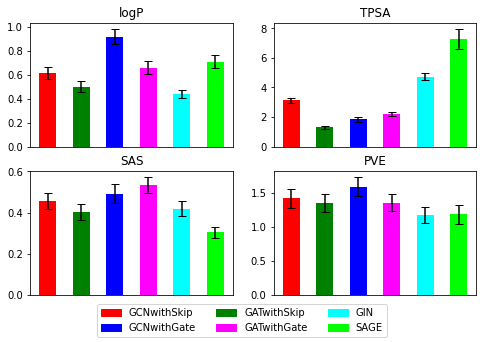

In [ ]:
title = 'One-hot feature training; MAE; Reproduce'
MAE_results = np.array([rearranged_results_GCNwithSkip[:,0],rearranged_results_GATwithSkip[:,0],rearranged_results_GCNwithGate[:,0],rearranged_results_GATwithGate[:,0],rearranged_results_GIN[:,0],rearranged_results_SAGE[:,0]])
std = np.array([0.1*rearranged_results_GCNwithSkip[:,1],0.1*rearranged_results_GATwithSkip[:,1],0.1*rearranged_results_GCNwithGate[:,1],0.1*rearranged_results_GATwithGate[:,1],0.1*rearranged_results_GIN[:,1],0.1*rearranged_results_SAGE[:,1]])
models = ['GCNwithSkip', 'GATwithSkip', 'GCNwithGate', 'GATwithGate','GIN','SAGE']
tests = ['logP', 'TPSA', 'SAS', 'PVE']
reproduce_result(MAE_results, std, models, tests,title)

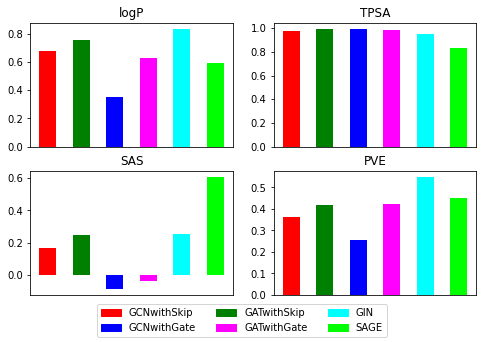

In [ ]:
title = 'One-hot feature training; R2; Reproduce'
R2_results = np.array([rearranged_results_GCNwithSkip[:,2],rearranged_results_GATwithSkip[:,2],rearranged_results_GCNwithGate[:,2],rearranged_results_GATwithGate[:,2],rearranged_results_GIN[:,2],rearranged_results_SAGE[:,2]])
std = None
models = ['GCNwithSkip', 'GATwithSkip', 'GCNwithGate', 'GATwithGate','GIN','SAGE']
tests = ['logP', 'TPSA', 'SAS', 'PVE']
reproduce_result(R2_results, std, models, tests,title)

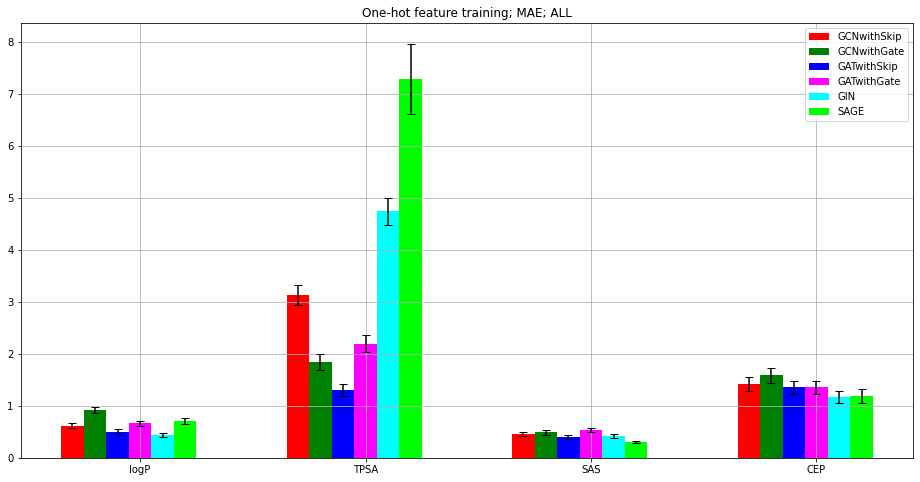

In [ ]:
title = 'One-hot feature training; MAE; ALL'
MAE_results = [rearranged_results_GCNwithSkip[:,0],rearranged_results_GCNwithGate[:,0],rearranged_results_GATwithSkip[:,0],rearranged_results_GATwithGate[:,0], rearranged_results_GIN[:,0], rearranged_results_SAGE[:,0]]
std = [0.1*rearranged_results_GCNwithSkip[:,1],0.1*rearranged_results_GCNwithGate[:,1],0.1*rearranged_results_GATwithSkip[:,1],0.1*rearranged_results_GATwithGate[:,1], 0.1*rearranged_results_GIN[:,1], 0.1*rearranged_results_SAGE[:,1]]
models = ['GCNwithSkip', 'GCNwithGate', 'GATwithSkip', 'GATwithGate','GIN','SAGE']
tests = ['logP', 'TPSA', 'SAS', 'CEP']
plot_result(MAE_results, std, models, tests,title)

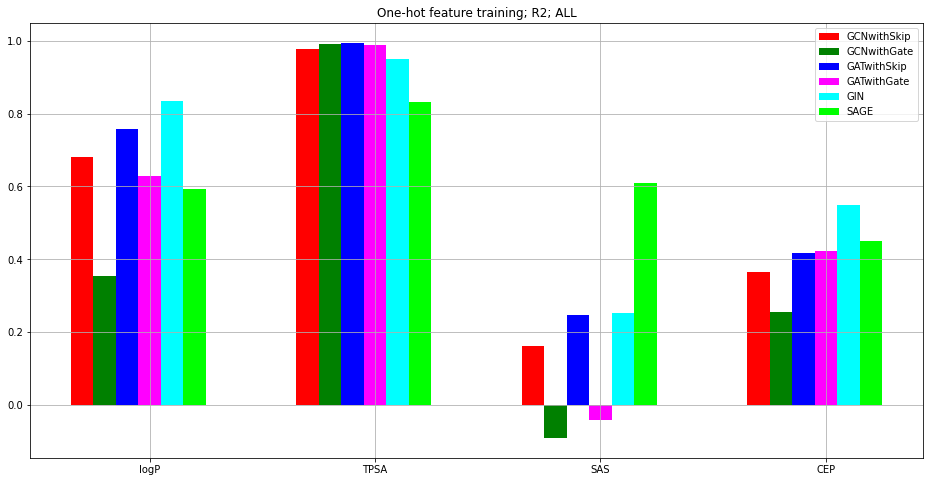

In [ ]:
title = 'One-hot feature training; R2; ALL'
R2_results = [rearranged_results_GCNwithSkip[:,2], rearranged_results_GCNwithGate[:,2], rearranged_results_GATwithSkip[:,2], rearranged_results_GATwithGate[:,2], rearranged_results_GIN[:,2], rearranged_results_SAGE[:,2]]
std = None
models = ['GCNwithSkip', 'GCNwithGate', 'GATwithSkip', 'GATwithGate','GIN','SAGE']
tests = ['logP', 'TPSA', 'SAS', 'CEP']
plot_result(R2_results, std, models, tests, title)